In [0]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the Amazon dataset
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# con = sqlite3.connect('/content/gdrive/My Drive/Colab Notebooks/Amazon_LSTM/database.sqlite')
con = sqlite3.connect('database.sqlite')

In [0]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
# Removing duplicate reviews
final=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

(364173, 10)


In [0]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [0]:
final["cleanReview"] = final["Summary"].map(str) + ". " + final["Text"]

In [0]:
final['cleanReview'].head()

0    Good Quality Dog Food. I have bought several o...
1    Not as Advertised. Product arrived labeled as ...
2    "Delight" says it all. This is a confection th...
3    Cough Medicine. If you are looking for the sec...
4    Great taffy. Great taffy at a great price.  Th...
Name: cleanReview, dtype: object

In [0]:
final['lengthOfReview'] = final['cleanReview'].str.split().str.len()
final['lengthOfReview'].head()

0    52
1    34
2    98
3    43
4    29
Name: lengthOfReview, dtype: int64

In [0]:
#remove urls from text python
from tqdm import tqdm
lst = []
removed_urls_list = []
for text in tqdm(final['cleanReview']):
  removed_urls_text = re.sub(r"http\S+", "", text)
  lst.append(removed_urls_text)

100%|██████████| 364171/364171 [00:00<00:00, 524870.27it/s]


In [0]:
#remove urls from text python
removed_urls_list = []
for text in tqdm(lst):
  removed_urls_text = re.sub(r"http\S+", "", text)
  removed_urls_list.append(removed_urls_text)

100%|██████████| 364171/364171 [00:00<00:00, 550092.84it/s]


In [0]:
from bs4 import BeautifulSoup
text_lst = []
for text in tqdm(removed_urls_list):
  soup = BeautifulSoup(text, 'lxml')
  text = soup.get_text()
  text_lst.append(text)
# print(text)
# print("="*50)

100%|██████████| 364171/364171 [01:16<00:00, 4733.42it/s]


In [0]:
print(len(final['cleanReview']))

364171


In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
decat_lst = []
for decat_text in tqdm(text_lst):
  text = decontracted(decat_text)
  decat_lst.append(text)

100%|██████████| 364171/364171 [00:04<00:00, 74805.38it/s]


In [0]:
strip_list = []
for to_strip in tqdm(decat_lst):
  text = re.sub("\S*\d\S*", "", to_strip).strip()
  strip_list.append(text)

100%|██████████| 364171/364171 [00:19<00:00, 18441.83it/s]


In [0]:

spatial_list = []
for to_spatial in tqdm(strip_list):
  text = re.sub('[^A-Za-z0-9]+', ' ', to_spatial)
  spatial_list.append(text)

100%|██████████| 364171/364171 [00:10<00:00, 34005.79it/s]


In [0]:

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(spatial_list):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [02:09<00:00, 2802.29it/s]


In [0]:
print(len(preprocessed_reviews))
preprocessed_reviews[-1]

364171


'great honey satisfied product advertised use cereal raw vinegar general sweetner'

In [0]:
final['cleanReview'] = preprocessed_reviews

In [0]:
print(len(final))
final.tail(5)

364171


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanReview,lengthOfReview
525809,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,1,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,not without great sesame chicken good not bett...,30
525810,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,0,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,disappointed disappointed flavor chocolate not...,47
525811,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,1,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",perfect maltipoo stars small give one training...,70
525812,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,1,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,favorite training reward treat best treats tra...,40
525813,568454,B001LR2CU2,A3LGQPJCZVL9UC,srfell17,0,0,1,1338422400,Great Honey,"I am very satisfied ,product is as advertised,...",great honey satisfied product advertised use c...,23


In [0]:
final['cleanReview'][0]

'good quality dog food bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

In [0]:
final['lengthOfReview'][0]

52

In [0]:
dir_path = os.getcwd()
conn = sqlite3.connect(os.path.join(dir_path, '/content/gdrive/My Drive/Colab Notebooks/Amazon_LSTM/final.sqlite'))
# conn = sqlite3.connect(os.path.join(dir_path, 'final.sqlite'))
# final.to_sql('Reviews', conn, if_exists='replace', index=False)

In [0]:
review_3 = pd.read_sql_query(""" SELECT count(*) FROM Reviews""", conn)
print(review_3)

   count(*)
0    364171


In [0]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews""", conn)

In [0]:
filtered_data.shape

(364171, 13)

In [0]:
filtered_data["Time"] = pd.to_datetime(filtered_data["Time"], unit = "s")
filtered_data = filtered_data.sort_values(by = "Time")

In [0]:

filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleanReview,lengthOfReview,Preprocessed_text
117924,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,EVERY book is educational. this witty little b...,78,witty little book makes son laugh loud recite ...
117901,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,This whole series is great way to spend time w...,90,remember seeing show aired television years ag...
298792,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,Entertainingl Funny!. Beetlejuice is a well wr...,31,beetlejuice well written movie everything exce...
169281,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",A modern day fairy tale. A twist of rumplestis...,41,twist rumplestiskin captured film starring mic...
298791,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,FANTASTIC!. Beetlejuice is an excellent and fu...,44,beetlejuice excellent funny movie keaton hilar...


In [0]:
print(len(filtered_data))
filtered_data.info()
filtered_data = filtered_data
print(len(filtered_data))

364171
<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 117924 to 107253
Data columns (total 13 columns):
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null int64
Time                      364171 non-null datetime64[ns]
Summary                   364171 non-null object
Text                      364171 non-null object
cleanReview               364171 non-null object
lengthOfReview            364171 non-null int64
Preprocessed_text         364171 non-null object
dtypes: datetime64[ns](1), int64(5), object(7)
memory usage: 38.9+ MB
364171


In [0]:
filtered_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [0]:
len(filtered_data['lengthOfReview'])

364171

In [0]:
X = filtered_data["cleanReview"]
print(print("shape of X:", X.head(5)))
y = filtered_data["Score"]
print("shape of y:", y.head(5))
X_len = filtered_data['lengthOfReview']

shape of X: 117924    EVERY book is educational. this witty little b...
117901    This whole series is great way to spend time w...
298792    Entertainingl Funny!. Beetlejuice is a well wr...
169281    A modern day fairy tale. A twist of rumplestis...
298791    FANTASTIC!. Beetlejuice is an excellent and fu...
Name: cleanReview, dtype: object
None
shape of y: 117924    1
117901    1
298792    1
169281    1
298791    1
Name: Score, dtype: int64


Vocabulary of all the words

In [0]:
# all_data = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 

In [0]:
complete_review = filtered_data["cleanReview"]

In [0]:
complete_review.head(5)

117924    every book educational witty little book makes...
117901    whole series great way spend time child rememb...
298792    entertainingl funny beetlejuice well written m...
169281    modern day fairy tale twist rumplestiskin capt...
298791    fantastic beetlejuice excellent funny movie ke...
Name: cleanReview, dtype: object

In [0]:
complete_review[0]

'good quality dog food bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better'

In [0]:
vocab_list = complete_review.astype(str).values.tolist()

In [0]:
vocab_list_strings = []
for words in vocab_list:
  vocab_list_strings.append(words.split())

In [0]:
word_list = [word for line in vocab_list for word in line.split()]

In [0]:
word_list[0]

'every'

In [0]:
from collections import Counter
counts = list(Counter(word_list).items())

In [0]:
print(counts[0])
print(len(counts))

('every', 24310)
122244


In [0]:
# counts[:100]
sorted_freq = sorted(counts, key=lambda x: x[1], reverse = True)

In [0]:
sorted_freq[:10]

[('not', 402056),
 ('like', 161348),
 ('great', 156532),
 ('good', 156003),
 ('taste', 115761),
 ('product', 111441),
 ('one', 110340),
 ('coffee', 101230),
 ('tea', 98173),
 ('love', 96957)]

In [0]:
top_words = sorted_freq[:5000]

In [0]:
vocab_list_strings[0]

['every',
 'book',
 'educational',
 'witty',
 'little',
 'book',
 'makes',
 'son',
 'laugh',
 'loud',
 'recite',
 'car',
 'driving',
 'along',
 'always',
 'sing',
 'refrain',
 'learned',
 'whales',
 'india',
 'drooping',
 'roses',
 'love',
 'new',
 'words',
 'book',
 'introduces',
 'silliness',
 'classic',
 'book',
 'willing',
 'bet',
 'son',
 'still',
 'able',
 'recite',
 'memory',
 'college']

In [0]:
for key, value in top_words[:10]:
  print(key, value)

not 402056
like 161348
great 156532
good 156003
taste 115761
product 111441
one 110340
coffee 101230
tea 98173
love 96957


In [0]:
from tqdm import tqdm
all_list = []
for ind_line in tqdm(vocab_list_strings):
    in_num = []
    for single_review in ind_line:
        for key, value in top_words:
            if key == single_review:
                new_review = value
                break
            else:
                new_review = 0
        in_num.append(new_review)
    all_list.append(in_num)

100%|██████████| 364171/364171 [45:53<00:00, 132.24it/s] 


In [0]:
import pickle
file = open('all_list', 'wb')
pickle.dump(all_list,file)
file.close()

In [0]:
print(all_list[0])
print(len(all_list))

[24310, 1608, 0, 0, 53562, 1608, 25031, 7873, 0, 283, 0, 1841, 458, 5336, 23736, 0, 0, 1826, 0, 907, 0, 403, 96957, 17728, 1346, 1608, 0, 0, 1858, 1608, 1142, 828, 7873, 27303, 11340, 0, 487, 1107]
364171


In [0]:
print(len(y))

364171


In [0]:
X_train = all_list[0:60000]
Y_train = y[0:60000]
X_val = all_list[60000:80000]
Y_val = y[60000:80000]
X_test = all_list[80000:100000]
Y_test = y[80000:100000]

In [0]:
max_review_length = 600
X_train_padded = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_val_padded = sequence.pad_sequences(X_val, maxlen=max_review_length)
X_test_padded = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [0]:
print(X_train_padded.shape)
print(len(Y_train))
print(X_val_padded.shape)
print(len(Y_val))
print(X_test_padded.shape)
print(len(Y_test))

(60000, 600)
60000
(20000, 600)
20000
(20000, 600)
20000


In [0]:
print(X_train_padded.shape)
print(X_train_padded[1])

(60000, 600)
[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0 

In [0]:
# create the model
top_words = 5000
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(500000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 32)           16000000  
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 16,053,301
Trainable params: 16,053,301
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
print(X_train_padded.shape)
print(X_val_padded.shape)
print(len(Y_train))
print(top_words)
print(embedding_vecor_length)
print(max_review_length)

(60000, 600)
(20000, 600)
60000
5000
32
600


In [0]:
X_val_padded

array([[     0,      0,      0, ...,   6984,  14877,   4413],
       [     0,      0,      0, ...,   1014, 115761,   7750],
       [     0,      0,      0, ...,  21100,  18430, 111441],
       ...,
       [     0,      0,      0, ...,      0,   1286,    580],
       [     0,      0,      0, ..., 156003,   5944,      0],
       [     0,      0,      0, ...,    948,    619,      0]], dtype=int32)

In [0]:
history = model.fit(X_train_padded, Y_train, epochs=5, batch_size=64, verbose=1, validation_data=(X_val_padded, Y_val))
# Final evaluation of the model
scores = model.evaluate(X_test_padded, Y_test, verbose=1)

Train on 60000 samples, validate on 20000 samples
Epoch 1/5
60000/60000 [==============================] - 1205s 20ms/step - loss: 0.2131 - acc: 0.9215 - val_loss: 0.1774 - val_acc: 0.9321
Epoch 2/5
60000/60000 [==============================] - 1210s 20ms/step - loss: 0.1417 - acc: 0.9477 - val_loss: 0.1550 - val_acc: 0.9402
Epoch 3/5
60000/60000 [==============================] - 1209s 20ms/step - loss: 0.1256 - acc: 0.9536 - val_loss: 0.1580 - val_acc: 0.9388
Epoch 4/5
60000/60000 [==============================] - 1192s 20ms/step - loss: 0.1162 - acc: 0.9579 - val_loss: 0.1584 - val_acc: 0.9371
Epoch 5/5
20000/20000 [==============================] - 272s 14ms/step


In [0]:
history.history

{'acc': [0.9214833333333333,
  0.9477,
  0.9536166666666667,
  0.9579,
  0.9616333333333333],
 'loss': [0.2130738423705101,
  0.14171525859038034,
  0.1256425191839536,
  0.11616440049012502,
  0.10702841568191847],
 'val_acc': [0.93205, 0.94015, 0.93885, 0.9371, 0.94145],
 'val_loss': [0.17739701343774797,
  0.1549874952316284,
  0.15804894822835922,
  0.15844768973588944,
  0.16001596611142158]}

In [0]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 94.17%


In [0]:
import pickle
file = open('1_layer_model', 'wb')
pickle.dump(model,file)
file.close()

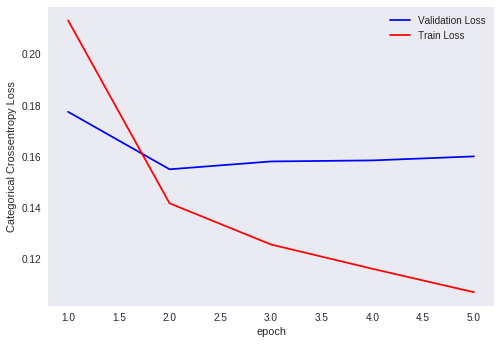

In [0]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
# plt_dynamic(x, vy, ty, ax)
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

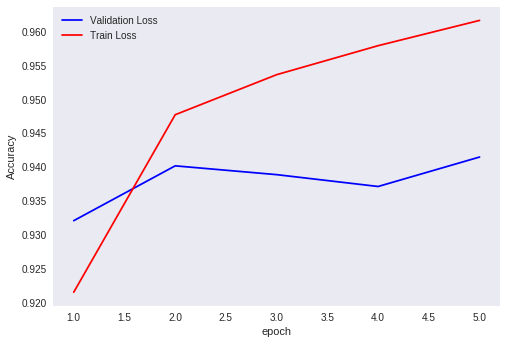

In [0]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Accuracy')
x = list(range(1,epochs+1))
vy = history.history['val_acc']
ty = history.history['acc']
# plt_dynamic(x, vy, ty, ax)
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

2 LSTM layers

In [0]:
# create the model
top_words = 5000
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(500000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 600, 32)           16000000  
_________________________________________________________________
lstm_4 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 16,133,701
Trainable params: 16,133,701
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
history = model.fit(X_train_padded, Y_train, nb_epoch=5, batch_size=64, verbose=1, validation_data=(X_val_padded, Y_val))
# Final evaluation of the model
scores = model.evaluate(X_test_padded, Y_test, verbose=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 60000 samples, validate on 20000 samples
Epoch 1/5
60000/60000 [==============================] - 2391s 40ms/step - loss: 0.1984 - acc: 0.9271 - val_loss: 0.1768 - val_acc: 0.9362
Epoch 2/5
60000/60000 [==============================] - 2378s 40ms/step - loss: 0.1408 - acc: 0.9479 - val_loss: 0.1545 - val_acc: 0.9391
Epoch 3/5
60000/60000 [==============================] - 2366s 39ms/step - loss: 0.1244 - acc: 0.9541 - val_loss: 0.1558 - val_acc: 0.9397
Epoch 4/5
60000/60000 [==============================] - 2384s 40ms/step - loss: 0.1120 - acc: 0.9588 - val_loss: 0.1636 - val_acc: 0.9423
Epoch 5/5
60000/60000 [==============================] - 2400s 40ms/step - loss: 0.0970 - acc: 0.9662 - val_loss: 0.1625 - val_acc: 0.9419


In [77]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 94.03%


In [0]:
import pickle
file = open('2_layer_model', 'wb')
pickle.dump(model,file)
file.close()

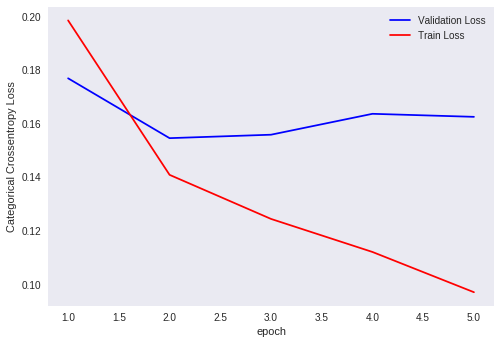

In [79]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
# plt_dynamic(x, vy, ty, ax)
ax.plot(x, vy, 'b', label="Validation Loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

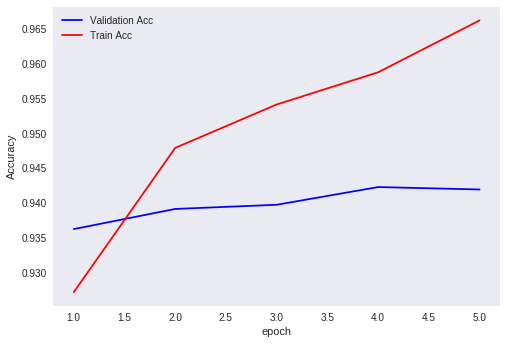

In [80]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Accuracy')
x = list(range(1,epochs+1))
vy = history.history['val_acc']
ty = history.history['acc']
# plt_dynamic(x, vy, ty, ax)
ax.plot(x, vy, 'b', label="Validation Acc")
ax.plot(x, ty, 'r', label="Train Acc")
plt.legend()
plt.grid()
fig.canvas.draw()

In [0]:
import pickle
with open(r"/content/gdrive/My Drive/Colab Notebooks/Amazon_LSTM/all_list", "rb") as input_file:
    all_list = pickle.load(input_file)

In [0]:
len(all_list)

364171

In [81]:
from keras.layers import Dropout
# create the model
top_words = 5000
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(500000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 600, 32)           16000000  
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 16,053,301
Trainable params: 16,053,301
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
print(X_train_padded.shape)
print(len(Y_train))
print(top_words)
print(embedding_vecor_length)
print(max_review_length)

(80000, 600)
80000
5000
32
600


In [0]:
print(X_train_padded.shape)
print(len(Y_train))
print(X_test_padded.shape)
print(len(Y_test))

(80000, 600)
80000
(20000, 600)
20000


In [83]:
history = model.fit(X_train_padded, Y_train, nb_epoch=5, batch_size=64, verbose=1, validation_data=(X_val_padded, Y_val))
# Final evaluation of the model
scores = model.evaluate(X_test_padded, Y_test, verbose=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 60000 samples, validate on 20000 samples
Epoch 1/5
60000/60000 [==============================] - 1211s 20ms/step - loss: 0.2026 - acc: 0.9253 - val_loss: 0.1698 - val_acc: 0.9365
Epoch 2/5
60000/60000 [==============================] - 1222s 20ms/step - loss: 0.1660 - acc: 0.9408 - val_loss: 0.1636 - val_acc: 0.9369
Epoch 3/5
60000/60000 [==============================] - 1216s 20ms/step - loss: 0.1287 - acc: 0.9535 - val_loss: 0.1604 - val_acc: 0.9385
Epoch 4/5
60000/60000 [==============================] - 1217s 20ms/step - loss: 0.1190 - acc: 0.9574 - val_loss: 0.1503 - val_acc: 0.9421
Epoch 5/5
60000/60000 [==============================] - 1218s 20ms/step - loss: 0.1107 - acc: 0.9598 - val_loss: 0.1543 - val_acc: 0.9405


In [84]:
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 93.95%


In [87]:
history.history

{'acc': [0.9253333333333333,
  0.9408166666666666,
  0.9535333333333333,
  0.9574,
  0.9597666666666667],
 'loss': [0.20257560855150222,
  0.16597173809806506,
  0.12868411589662235,
  0.11896670110026995,
  0.11065585671961307],
 'val_acc': [0.93655, 0.9369, 0.9385, 0.9421, 0.94055],
 'val_loss': [0.16982482701539994,
  0.16357549469470978,
  0.1604027135014534,
  0.1503286645948887,
  0.15434236347675323]}

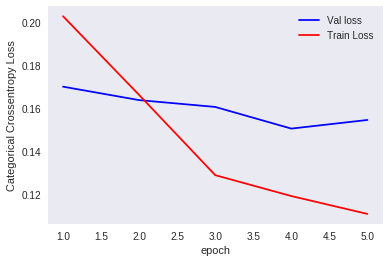

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline
epochs = 5
# score = model.evaluate(X_test_padded, Y_test, verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
# plt_dynamic(x, vy, ty, ax)
ax.plot(x, vy, 'b', label="Val loss")
ax.plot(x, ty, 'r', label="Train Loss")
plt.legend()
plt.grid()
fig.canvas.draw()

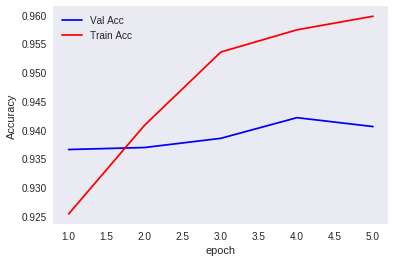

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline
epochs = 5
# score = model.evaluate(X_test_padded, Y_test, verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Accuracy')
x = list(range(1,epochs+1))
vy = history.history['val_acc']
ty = history.history['acc']
# plt_dynamic(x, vy, ty, ax)
ax.plot(x, vy, 'b', label="Val Acc")
ax.plot(x, ty, 'r', label="Train Acc")
plt.legend()
plt.grid()
fig.canvas.draw()

In [91]:
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["Number of LSTM layers", "Accuracy"]

x.add_row(["1 layer", "94.17%"])
x.add_row(["2 layer", "94.03%"])
x.add_row(["1 layer with dropout rate = 0.5", "93.95%"])
print(x)

+---------------------------------+----------+
|      Number of LSTM layers      | Accuracy |
+---------------------------------+----------+
|             1 layer             |  94.17%  |
|             2 layer             |  94.03%  |
| 1 layer with dropout rate = 0.5 |  93.95%  |
+---------------------------------+----------+


Procedure followed

1. Preprocessed the Amazon fine food dataset
2. Created the vocabulary
3. Indexed the words based on frequency
4. Made the dataset same as that with IMdb dataset
5. Trained the LSTM model with 1 layer
6. Trained the LSTM model with 2 layers